In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

Phase 1-Recherche et acquisition des données 

In [2]:
df1=pd.read_csv("D:/ingv 4/S2/open data/TP3/1900_2021_DISASTERS.xlsx - emdat data.csv")
df2=pd.read_excel("D:/ingv 4/S2/open data/TP3/public_emdat_custom_request_2025-04-01_074ba978-f484-4814-b703-12ef55f2c9f9.xlsx")

Harmonisation du nom des colonnes 

In [3]:
column_mapping = {
    "DisNo.": "Seq",
    "Classification Key": "Disaster Type",
    "Magnitude": "Dis Mag Value",
    "Magnitude Scale": "Dis Mag Scale",
    "Latitude": "Latitude",
    "Longitude": "Longitude",
    "Total Deaths": "Total Deaths",
    "No. Injured": "No Injured",
    "No. Affected": "No Affected",
    "No. Homeless": "No Homeless",
    "Total Affected": "Total Affected",
    "Insured Damage ('000 US$)": "Insured Damages ('000 US$)",
    "Total Damage ('000 US$)": "Total Damages ('000 US$)",
    "CPI": "CPI",
    "Country": "Country",
    "ISO": "ISO",
    "Region": "Region",
    "Start Year": "Start Year",
    "Start Month": "Start Month",
    "Start Day": "Start Day",
    "End Year": "End Year",
    "End Month": "End Month",
    "End Day": "End Day"
}

df2_renamed = df2.rename(columns=column_mapping)

On selectionne les colonnes qu'il y a en commun 

In [4]:
common_columns = list(set(df1.columns) & set(df2_renamed.columns))
df1_filtered = df1[common_columns]
df2_filtered = df2_renamed[common_columns]

On réinitialise les indexs et on suppprime les doublons 

In [5]:
df1_filtered = df1_filtered.loc[:, ~df1_filtered.columns.duplicated()].reset_index(drop=True)
df2_filtered = df2_filtered.loc[:, ~df2_filtered.columns.duplicated()].reset_index(drop=True)

On fusionne les datasets 

In [6]:
df = pd.concat([df1_filtered, df2_filtered], ignore_index=True)

On sauvegarde 

In [7]:
df.to_excel("merged_disaster_data.xlsx", index=False)

In [8]:
df.shape

(32704, 32)

Tache 2- Prétaraitement et Analyse aléatoire 

Nettoyage des données et outliers 

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
df.fillna(df.median(numeric_only=True), inplace=True)  # Remplacer NaN par la médiane
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]  # Suppression des outliers

Calcul de moyenne mobiles et tendances 

In [10]:
df['Total Damages Moving Avg'] = df['Total Damages (\'000 US$)'].rolling(window=5, min_periods=1).mean()


Détections d'Anomalies 

In [11]:
df['Anomaly'] = np.abs(df['Total Damages (\'000 US$)'] - df['Total Damages Moving Avg']) > (2 * df['Total Damages Moving Avg'].std())


Calcul des tendances linéaires 

In [12]:
def linear_trend(series):
    x = np.arange(len(series))
    y = series.values
    slope, intercept, _, _, _ = stats.linregress(x, y)
    return slope * x + intercept

df['Trend Total Damages'] = linear_trend(df['Total Damages (\'000 US$)'])

Recherche des Indicateurs climatiques 

In [13]:
df['Annual Temperature Change'] = df.groupby('Start Year')['Total Damages (\'000 US$)'].transform(lambda x: x.mean())
df['Variability Interannuelle'] = df.groupby('Start Year')['Total Damages (\'000 US$)'].transform(lambda x: x.std())

Affichage des tendances 

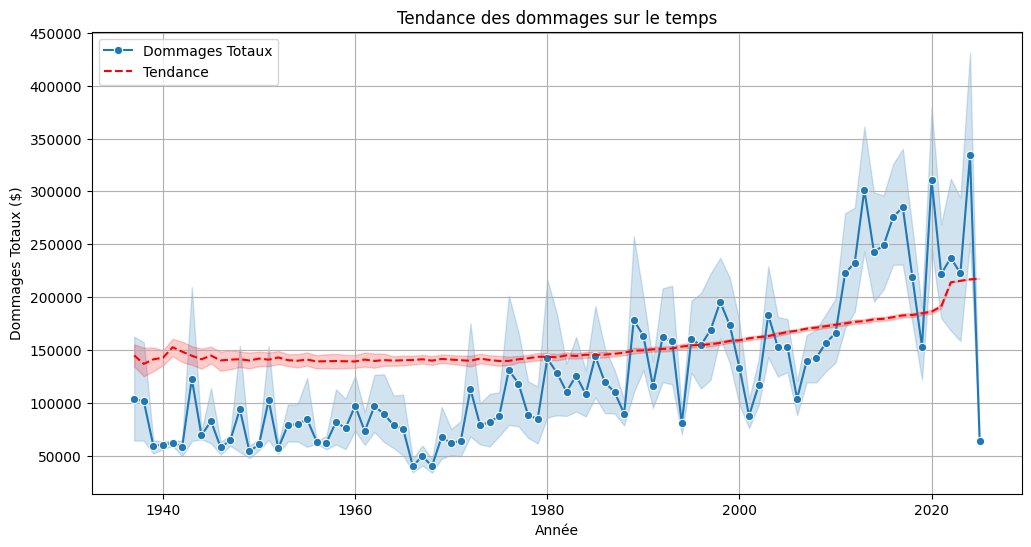

In [14]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Start Year'], y=df['Total Damages (\'000 US$)'], label='Dommages Totaux', marker='o')
sns.lineplot(x=df['Start Year'], y=df['Trend Total Damages'], label='Tendance', linestyle='dashed', color='red')
plt.xlabel('Année')
plt.ylabel('Dommages Totaux ($)')
plt.title('Tendance des dommages sur le temps')
plt.legend()
plt.grid(True)
plt.show()



J'ai choisi de tracer plusieurs graphiques qui sont : 
    => Un graphique en barre qui représente les dommages par année 
    => Une Heatmap de corrélation 

C:\Users\lealh\AppData\Local\Temp\ipykernel_105532\3208556322.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Start Year', y='Total Damages (\'000 US$)', ci=None, color='royalblue')


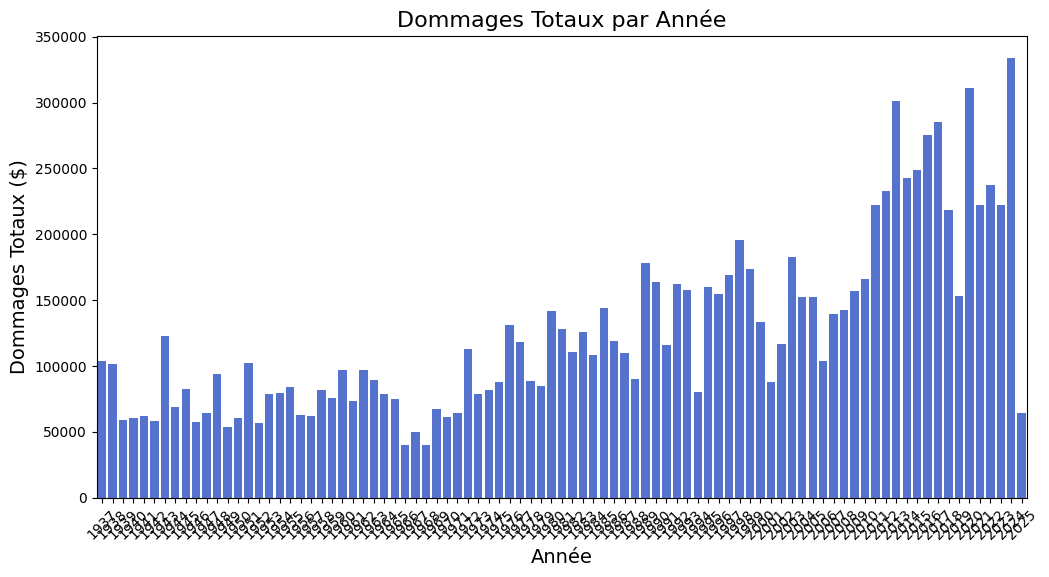

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Start Year', y='Total Damages (\'000 US$)', ci=None, color='royalblue')
plt.xlabel('Année', fontsize=14)
plt.ylabel('Dommages Totaux ($)', fontsize=14)
plt.title('Dommages Totaux par Année', fontsize=16)
plt.xticks(rotation=45)
plt.show()

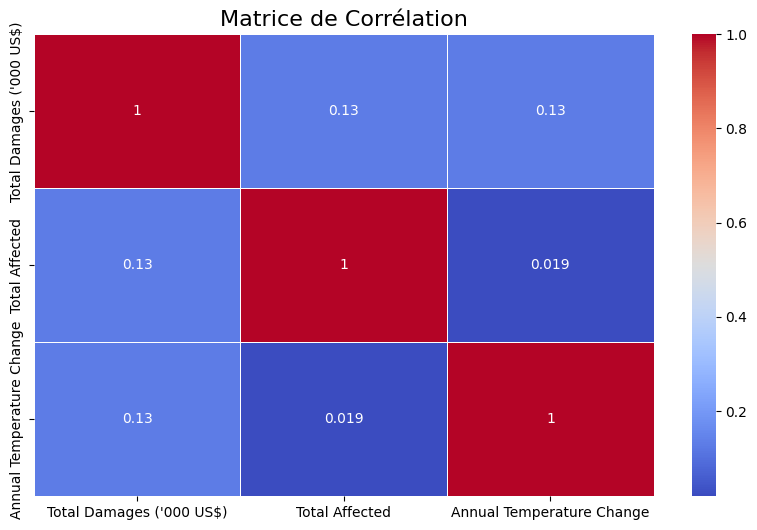

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Total Damages (\'000 US$)', 'Total Affected', 'Annual Temperature Change']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation', fontsize=16)
plt.show()


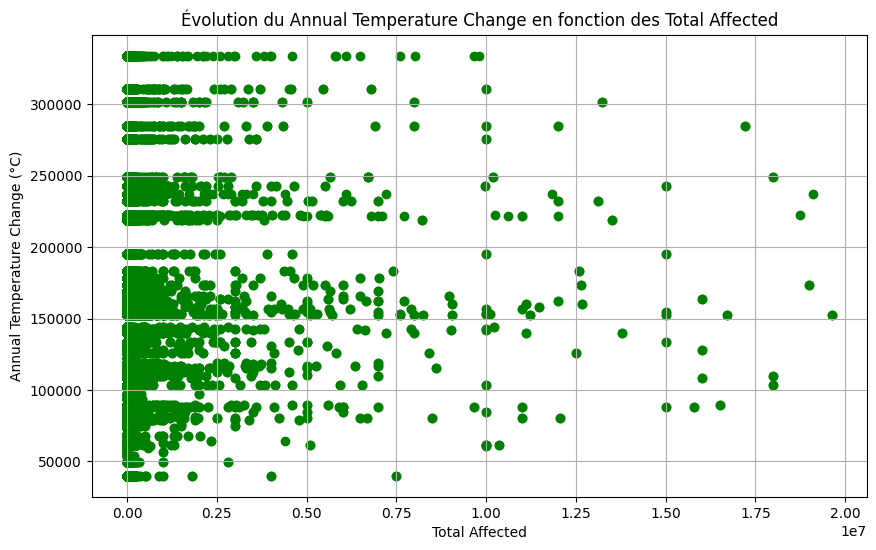

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Total Affected'], df['Annual Temperature Change'], color='green')
plt.title('Évolution du Annual Temperature Change en fonction des Total Affected')
plt.xlabel('Total Affected')
plt.ylabel('Annual Temperature Change (°C)')
plt.grid(True)
plt.show()

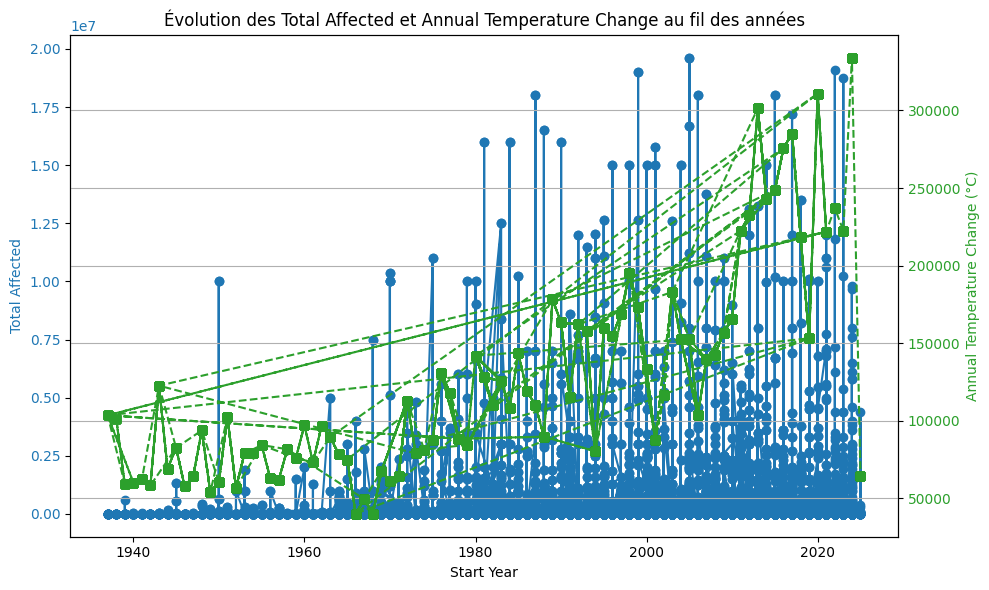

In [25]:
# Création du graphique
fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracé de la première courbe (Total Affected)
ax1.set_xlabel('Start Year')
ax1.set_ylabel('Total Affected', color='tab:blue')
ax1.plot(df['Start Year'], df['Total Affected'], color='tab:blue', marker='o', label='Total Affected')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Création d'un deuxième axe y pour la deuxième courbe
ax2 = ax1.twinx()
ax2.set_ylabel('Annual Temperature Change (°C)', color='tab:green')
ax2.plot(df['Start Year'], df['Annual Temperature Change'], color='tab:green', marker='s', label='Annual Temperature Change', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Ajout d'un titre et d'une grille
plt.title('Évolution des Total Affected et Annual Temperature Change au fil des années')
fig.tight_layout()
plt.grid(True)

# Affichage du graphique
plt.show()

Phase 3-Visualisation spatiale et géographique 